# Pairs / Spread Analysis (Kalman Hedge Ratio + Adaptive Z-Score)

This notebook is a compact, reproducible research workflow for cross-asset pairs/spread analysis:

1. Load and **align** close prices (calendar alignment matters).
2. Build a **time-varying hedge ratio** with a lightweight Kalman filter in log-price space.
3. Define the **spread** as the regression residual.
4. Compute an **adaptive z-score** (EWM mean/std).
5. Quantify behavior with: **half-life**, **ACF lags**, **ADF/KPSS**, and **z-score event stats**.
6. Run a small **ZSPAN sensitivity** check.

> Notes  
> - This is a research notebook, not a production trading system.  
> - Results depend on the chosen pair, frequency, calendar alignment, and transaction costs.

Jump to: [Table of contents](#toc)


<a id="toc"></a>
## Table of contents

- [Methods](#methods)
  - [Setup](#setup)
  - [Load and inspect data](#data)
  - [Rolling correlation](#corr)
  - [Kalman hedge ratio and spread](#kalman)
- [Results](#results)
  - [Spread diagnostics](#diagnostics)
  - [Adaptive z-score and event statistics](#zscore)
  - [ZSPAN sensitivity check](#sensitivity)


<a id="methods"></a>
## Methods


<a id="setup"></a>
## 0) Setup

This cell makes the repository root importable (so `import src.core as core` works) and defines all configurable parameters in one place.


In [4]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

# Ensure the repository root (with `src/`) is importable
here = Path().resolve()
root = here if (here / "src").exists() else here.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import src.core as core

# ----------------------------
# Pair configuration
# ----------------------------
ASSET_Y = "BTC-USD"
ASSET_X = "QQQ"

# ----------------------------
# Data / alignment
# ----------------------------
CSV_PATH = root /"data"/"raw"/"prices.csv"     # update if needed
ALIGN = "inner"                      # recommended for 24/7 vs session-based markets

# ----------------------------
# Kalman (time-varying hedge ratio)
# ----------------------------
DELTA = 1e-5                         # higher => faster adaptation of alpha/beta
R = 1e-3                             # higher => smoother estimates
INCLUDE_INTERCEPT = True
BURN_IN = 100                        # discard early Kalman transient for plots/metrics

# ----------------------------
# Z-score + events
# ----------------------------
ZSPAN_DEFAULT = 45                   # default for the main plots
ENTRY_Z = 2.0
EXIT_Z = 0.5

# Sensitivity check
ZSPANS = [30, 45, 60]


<a id="data"></a>
## 1) Load and inspect data

We load close prices and apply calendar alignment.

- `align="inner"` keeps **only timestamps where both assets have real data**.
  This avoids forward-filling session-market assets across weekends when paired with 24/7 assets.


,BTC-USD,QQQ
Date,,
2025-11-21,85090.687500,590.070007
2025-11-24,88270.562500,605.159973
2025-11-25,87341.890625,608.890015
2025-11-26,90518.367188,614.270020
2025-11-28,90919.265625,619.250000


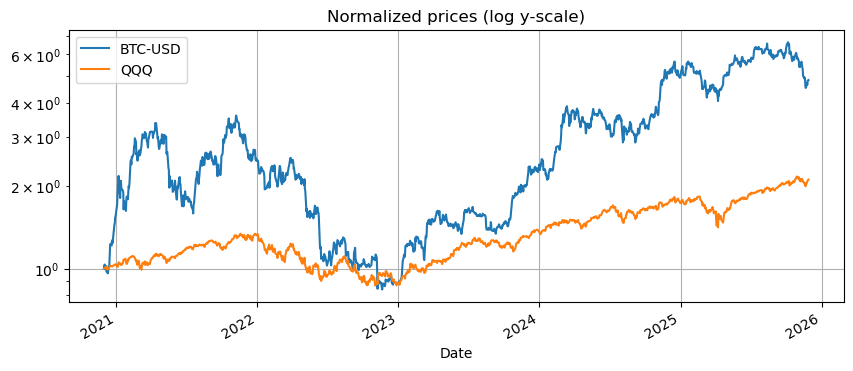

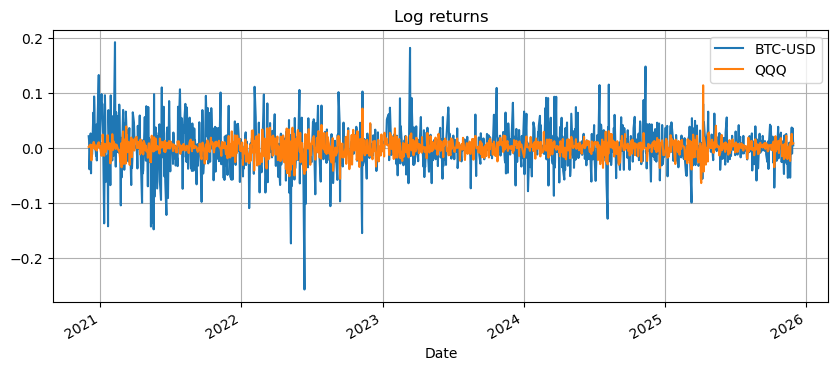

In [5]:
closes = core.load_and_prepare_closes(CSV_PATH, align=ALIGN)
display(closes.tail())

# Quick visual checks
base = closes / closes.iloc[0]
ax = base.plot(logy=True, figsize=(10, 4), title="Normalized prices (log y-scale)")
ax.grid(True)

returns = core.compute_log_returns(closes)
ax = returns.plot(figsize=(10, 4), title="Log returns")
ax.grid(True)


<a id="corr"></a>
## 2) Rolling correlation (diagnostic)

Rolling correlation on **returns** is useful for context, but it is not a cointegration test.


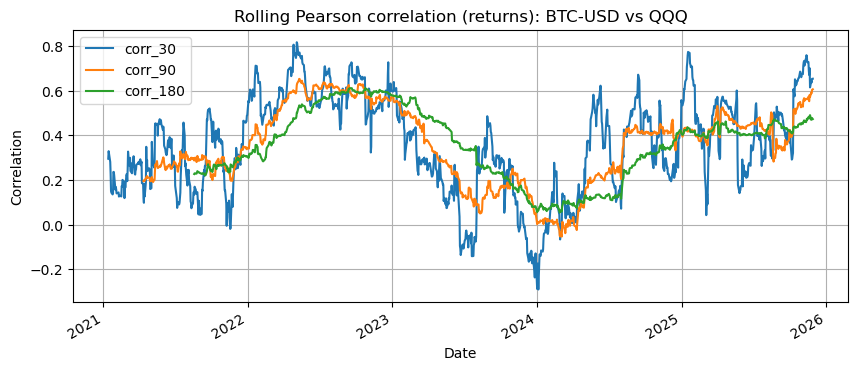

In [6]:
corr = core.rolling_correlation_dual(returns, ASSET_X, ASSET_Y, 30, 90, 180)
ax = corr.plot(figsize=(10, 4))
ax.set_title(f"Rolling Pearson correlation (returns): {ASSET_Y} vs {ASSET_X}")
ax.set_xlabel("Date")
ax.set_ylabel("Correlation")
ax.grid(True)


<a id="kalman"></a>
## 3) Time-varying hedge ratio (Kalman) and spread

We model:


## y_t = alpha_t + beta_t * x_t + varepsilon_t

where ; 
     
     y_t = log(Y_t) ; x_t = log(X_t) 

The **spread** is the residual (varepsilon_t).  
Kalman filtering lets alpha_t and beta_t **evolve over time**.


In [7]:
log_prices = core.compute_log_prices(closes)

k = core.kalman_hedge_ratio(
    log_prices,
    asset_y=ASSET_Y,
    asset_x=ASSET_X,
    delta=DELTA,
    r=R,
    include_intercept=INCLUDE_INTERCEPT,
).dropna()

print("Latest alpha:", float(k["alpha"].iloc[-1]))
print("Latest beta :", float(k["beta"].iloc[-1]))


Latest alpha: 4.748962363497102
Latest beta : 1.0371144141888702


### 3.1) Dual-axis plot (spread vs beta)

The spread is typically small (log units) compared with beta, so we use two y-axes for readability.


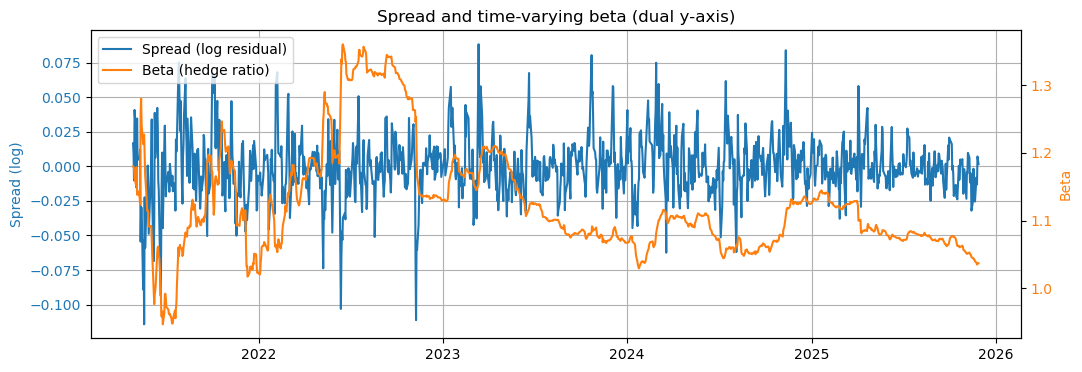

In [8]:
df_plot = k[["spread", "beta"]].iloc[BURN_IN:].dropna()

fig, ax1 = plt.subplots(figsize=(12, 4))

# Spread (left axis)
color_spread = "tab:blue"
ax1.plot(df_plot.index, df_plot["spread"], color=color_spread, linewidth=1.5, label="Spread (log residual)")
ax1.set_ylabel("Spread (log)", color=color_spread)
ax1.tick_params(axis="y", labelcolor=color_spread)
ax1.grid(True)

# Beta (right axis)
ax2 = ax1.twinx()
color_beta = "tab:orange"
ax2.plot(df_plot.index, df_plot["beta"], color=color_beta, linewidth=1.5, label="Beta (hedge ratio)")
ax2.set_ylabel("Beta", color=color_beta)
ax2.tick_params(axis="y", labelcolor=color_beta)

ax1.set_title("Spread and time-varying beta (dual y-axis)")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()


<a id="results"></a>
## Results


<a id="diagnostics"></a>
## 4) Spread diagnostics (stationarity + dynamics)

We compute:
- Half-life (mean-reversion speed, in bars)
- Autocorrelation at a few lags
- ADF / KPSS (optional; requires `statsmodels`)


Half-life estimate (bars): 1.16
Autocorrelation by lag: {1: 0.5498860423492095, 2: 0.31370653452950403, 5: 0.010199245652135196, 10: 0.03043858214612893, 20: 0.005005593721795075}
ADF : {'adf_stat': -18.301374809948516, 'pvalue': 2.286208731004147e-30}
KPSS: {'kpss_stat': 0.1791073922565484, 'pvalue': 0.1}


C:\Users\siste\Desktop\CURSOS\Aprendizaje Trader Algo\Proyectos_trading_algoritmico\Cross_assets_pair_analyzer\src\core.py:339: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, *_ = kpss(s, regression=regression, nlags=nlags)


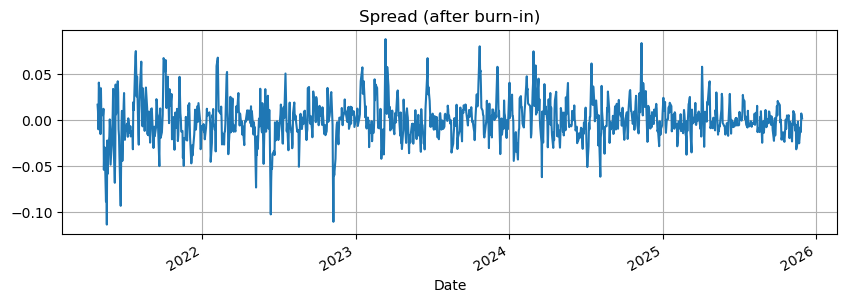

In [9]:
spread = k["spread"].iloc[BURN_IN:].dropna()

# Half-life (in bars)
hl = core.half_life(spread)
print(f"Half-life estimate (bars): {hl:.2f}")

# Autocorrelation at selected lags
lags = [1, 2, 5, 10, 20]
ac = {lag: float(spread.autocorr(lag=lag)) for lag in lags}
print("Autocorrelation by lag:", ac)

# Stationarity tests (optional: requires statsmodels)
try:
    print("ADF :", core.adf_test(spread))
    print("KPSS:", core.kpss_test(spread))
except Exception as e:
    print("ADF/KPSS not available (install statsmodels):", e)

# Quick distribution view
ax = spread.plot(figsize=(10, 3), title="Spread (after burn-in)")
ax.grid(True)


<a id="zscore"></a>
## 5) Adaptive z-score and event statistics

We compute an adaptive z-score:

\[
z_t = \frac{s_t - \mu_t}{\sigma_t}
\]

where \(\mu_t\) and \(\sigma_t\) are exponentially-weighted estimates.

An **event** starts when \(|z|\geq \text{ENTRY\_Z}\) and ends when \(|z|\leq \text{EXIT\_Z}\).


In [10]:
def zscore_events(z: pd.Series, entry: float = 2.0, exit: float = 0.5) -> pd.DataFrame:
    """Parse z-score into discrete events (entry at ±entry, exit when |z|<=exit)."""
    z = z.dropna().copy()

    state = 0  # 0=flat, +1=SHORT (z>entry), -1=LONG (z<-entry)
    start_t = None
    start_z = None
    peak_z = None

    events = []

    for t, val in z.items():
        if state == 0:
            if val >= entry:
                state = +1
                start_t, start_z, peak_z = t, val, val
            elif val <= -entry:
                state = -1
                start_t, start_z, peak_z = t, val, val
        else:
            if state == +1:
                peak_z = max(peak_z, val)
            else:
                peak_z = min(peak_z, val)

            if abs(val) <= exit:
                end_t = t
                duration = z.index.get_loc(end_t) - z.index.get_loc(start_t)
                events.append(
                    {
                        "side": "SHORT" if state == +1 else "LONG",
                        "start": start_t,
                        "end": end_t,
                        "duration_bars": int(duration),
                        "z_start": float(start_z),
                        "z_peak": float(peak_z),
                        "z_end": float(val),
                    }
                )
                state = 0
                start_t = start_z = peak_z = None

    return pd.DataFrame(events)


def event_summary(events_df: pd.DataFrame, z: pd.Series, entry: float = 2.0) -> dict:
    """High-level event KPIs."""
    z2 = z.dropna()
    n_bars = int(len(z2))
    n_events = int(len(events_df))

    out = {
        "bars": n_bars,
        "events": n_events,
        "events_per_1000_bars": (n_events / n_bars * 1000) if n_bars else np.nan,
        "pct_time_abs_z_gt_entry": float((z2.abs() > entry).mean() * 100) if n_bars else np.nan,
    }

    if n_events:
        out.update(
            {
                "duration_mean": float(events_df["duration_bars"].mean()),
                "duration_median": float(events_df["duration_bars"].median()),
                "duration_p90": float(events_df["duration_bars"].quantile(0.90)),
                "count_LONG": int((events_df["side"] == "LONG").sum()),
                "count_SHORT": int((events_df["side"] == "SHORT").sum()),
            }
        )
    return out


,side,start,end,duration_bars,z_start,z_peak,z_end
0,SHORT,2021-07-26,2021-08-04,7,2.375596,2.375596,0.127649
1,SHORT,2021-10-01,2021-10-07,4,2.324810,2.324810,0.129476
2,LONG,2022-01-21,2022-01-26,3,-2.028611,-2.028611,0.480323
3,SHORT,2022-02-04,2022-02-09,3,2.824318,2.824318,0.313095
4,SHORT,2022-02-28,2022-03-02,2,2.009830,2.009830,0.386859
5,LONG,2022-05-09,2022-05-12,3,-3.417207,-3.417207,-0.488423
6,LONG,2022-06-13,2022-06-23,7,-3.298479,-3.298479,0.438411
7,SHORT,2022-07-18,2022-07-20,2,2.113614,2.113614,0.189849
8,LONG,2022-08-19,2022-08-24,3,-2.015663,-2.015663,0.218713
9,SHORT,2022-09-09,2022-09-13,2,2.015251,2.015251,0.490301


{'bars': 1111, 'events': 32, 'events_per_1000_bars': 28.802880288028803, 'pct_time_abs_z_gt_entry': 3.6003600360036003, 'duration_mean': 3.46875, 'duration_median': 3.0, 'duration_p90': 6.900000000000002, 'count_LONG': 16, 'count_SHORT': 16}


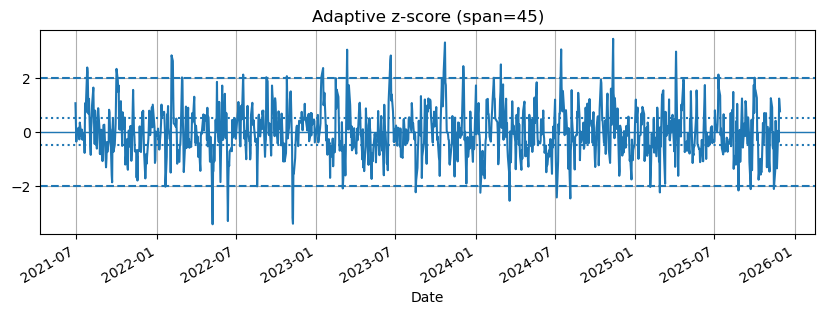

In [11]:
z = core.zscore_ewm(spread, span=ZSPAN_DEFAULT)

ax = z.plot(figsize=(10, 3), title=f"Adaptive z-score (span={ZSPAN_DEFAULT})")
ax.axhline(ENTRY_Z, linestyle="--")
ax.axhline(-ENTRY_Z, linestyle="--")
ax.axhline(EXIT_Z, linestyle=":")
ax.axhline(-EXIT_Z, linestyle=":")
ax.axhline(0, linewidth=1)
ax.grid(True)

events = zscore_events(z, entry=ENTRY_Z, exit=EXIT_Z)
display(events.head(10))

summary = event_summary(events, z, entry=ENTRY_Z)
print(summary)


<a id="sensitivity"></a>
## 6) ZSPAN sensitivity check

We compare `ZSPAN ∈ {30, 45, 60}` using the same entry/exit rules and report event KPIs.


In [12]:
rows = []
for span in ZSPANS:
    z_span = core.zscore_ewm(spread, span=span)
    ev = zscore_events(z_span, entry=ENTRY_Z, exit=EXIT_Z)
    summ = event_summary(ev, z_span, entry=ENTRY_Z)
    summ["zspan"] = span
    rows.append(summ)

df_spans = pd.DataFrame(rows).set_index("zspan").sort_index()
display(df_spans)


,bars,events,events_per_1000_bars,pct_time_abs_z_gt_entry,duration_mean,duration_median,duration_p90,count_LONG,count_SHORT
zspan,,,,,,,,,
30,1126,33,29.307282,3.463588,3.303030,3.0,5.0,16,17
45,1111,32,28.802880,3.600360,3.468750,3.0,6.9,16,16
60,1096,29,26.459854,3.467153,3.758621,3.0,7.0,13,16
